In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist

In [2]:
(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()
print('X Train Shape: ', xtrain.shape)
print('X Test Shape: ', xtest.shape)
print('Y Train Shape: ', ytrain.shape)
print('Y Test Shape: ', ytest.shape)
print('Number of classes: ', len(set(ytrain)))

class_labels = {0: 'T-Shirt',
                1: 'Trouser',
                2: 'Pullover',
                3: 'Dress',
                4: 'Coat',
                5: 'Sandal',
                6: 'Shirt',
                7: 'Sneaker',
                8: 'Bag',
                9: 'Ankle Boot'}

4422102/4422102 [==============================] - 0s 0us/step
X Train Shape:  (60000, 28, 28)
X Test Shape:  (10000, 28, 28)
Y Train Shape:  (60000,)
Y Test Shape:  (10000,)
Number of classes:  10


In [3]:
xtrain_inp = xtrain.reshape((xtrain.shape[0], -1))/255
xtest_inp = xtest.reshape((xtest.shape[0], -1))/255
ytrain_inp = np.array(pd.get_dummies(ytrain))
ytest_inp = np.array(pd.get_dummies(ytest))

# Question 1

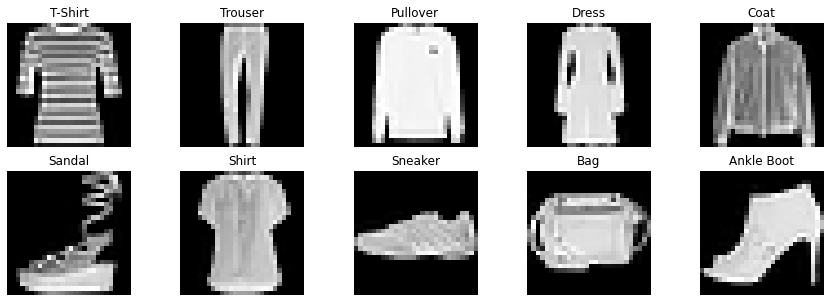

In [4]:
i = 5 # can change to view different images
idxs = {k:np.where(ytrain==k)[0][i] for k in set(ytrain)}
fig, axs = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(xtrain[idxs[i], :, :], cmap='gray')
  ax.set_title(class_labels[i])
  ax.axis('off')

## Helper Functions

In [12]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_der(x):
  return sigmoid(x) * (1-sigmoid(x))

def relu(x):
  return np.maximum(0, x)

def relu_der(x):
  x[x>0] = 1
  x[x<=0] = 0
  return x

def tanh(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_der(x):
  return 1 - tanh(x) ** 2

def identity(x):
  return x

def identity_der(x):
  return np.ones(x.shape)

def get_activation(act):
  if act == 'sigmoid':
    act = sigmoid
    act_der = sigmoid_der
  elif act == 'ReLU':
    act = relu
    act_der = relu_der
  elif act== 'tanh':
    act = tanh
    act_der = tanh_der
  elif act == 'identity':
    act = identity
    act_der = identity_der
  else:
    raise Exception('Incorrect Activation Function')
  return act, act_der

def softmax(x):
  xsum = np.sum(np.exp(x), axis=1, keepdims=True)
  res = np.exp(x)/xsum
  return res

def cross_entropy(y, yhat):
  """ 
  Returns Average Cross Entropy Loss over the input data points
  - Epsilon is used so that log is not taken over 0
  """
  epsilon = 1e-30
  losses = -np.sum(y * np.log(yhat + epsilon), axis=1)
  return np.mean(losses)

def cross_entropy_der(y, yhat):
  return -(y - yhat)

def mean_squared_error(y, yhat):
  return np.mean(np.sum((y-yhat)**2, axis=1))

def mean_squared_error_der(y, yhat):
  pass

def accuracy(y, yhat):
  return np.sum(np.argmax(y, axis=1) ==  np.argmax(yhat, axis=1))

# Question 2

In [13]:
def init_params(n_inp, n_hidden, n_out, seed=None):
  if seed is not None:
    np.random.seed(seed)
  NN = [n_inp] + n_hidden + [n_out]
  params = {}
  for i in range(1, len(NN)):
    params['W' + str(i)] = np.random.randn(NN[i-1], NN[i]) * 0.01
    params['B' + str(i)] = np.zeros((1, NN[i]))
  return params

def forward(inp, params, activation):
  L = len(params) // 2
  cache = {'H0':inp}
  for i in range(1, L+1):
    cache['A' + str(i)] = cache['H' + str(i-1)] @ params['W' + str(i)] + params['B' + str(i)]
    cache['H' + str(i)] = sigmoid(cache['A' + str(i)])
  cache['A' + str(L)] = cache['H' + str(L-1)] @ params['W' + str(L)] + params['B' + str(L)]
  cache['H' + str(L)] = softmax(cache['A' + str(L)])
  yhat = cache['H' + str(L)]
  return yhat, cache

# Question 3

In [24]:
def backward(y, params, yhat, cache, act_der, loss_func):
  L = len(params) // 2
  m = y.shape[0]
  
  if loss_func == 'cross_entropy':
    loss_func_ = cross_entropy
    loss_func_der = cross_entropy_der
  elif loss_func == 'mean_squared_error':
    loss_func_ = mean_squared_error
    loss_func_der = mean_squared_error_der
  else:
    raise Exception('Incorrect Loss Function')
  loss = loss_func_(y, yhat)
  acc = accuracy(y, yhat)
  del_params = {} 
  del_ak = loss_func_der(y, yhat)
  for k in range(L, 0, -1):
    del_params['W' + str(k)] = (cache['H' + str(k-1)].T @ del_ak) / m
    del_params['B' + str(k)] = np.sum(del_ak, axis=0, keepdims=True) / m
    if k != 1:
      del_ak = (del_ak @ params['W' + str(k)].T) * act_der(cache['A' + str(k-1)])
  return del_params, loss, acc


In [29]:
def train(xtrain, ytrain, n_hidden, activation = 'sigmoid', loss_func = 'cross_entropy', optim = 'SGD', momentum=0.9, LR=1e-2, EPOCHS=100, BATCH_SIZE=32, seed=None):
  if seed is not None:
    np.random.seed(0)
  params = init_params(n_inp = xtrain.shape[1], n_hidden = n_hidden, n_out = ytrain.shape[1], seed = seed)

  act, act_der = get_activation(activation)

  U = {k:0 for k in params.keys()}

  for i in range(1, EPOCHS+1):

    # if optim == 'SGD':
    #   batches = np.arange(xtrain.shape[0])
    #   np.random.shuffle(batches)
    #   batches = [[k] for k in batches]
    # else:
    #   temp = np.arange(xtrain.shape[0])
    #   np.random.shuffle(temp)
    #   n_batches = xtrain.shape[0] // BATCH_SIZE
    #   batches = temp[:n_batches*BATCH_SIZE].reshape(-1, BATCH_SIZE).tolist()
    #   if  xtrain.shape[0] % BATCH_SIZE != 0:
    #     batches = batches + [temp[n_batches*BATCH_SIZE:].tolist()]

    temp = np.arange(xtrain.shape[0])
    np.random.shuffle(temp)
    n_batches = xtrain.shape[0] // BATCH_SIZE
    batches = temp[:n_batches*BATCH_SIZE].reshape(-1, BATCH_SIZE).tolist()
    if  xtrain.shape[0] % BATCH_SIZE != 0:
      batches = batches + [temp[n_batches*BATCH_SIZE:].tolist()]

    loss = []
    acc = []

    for batch in batches:
      yhat, cache = forward(xtrain[batch, :], params, act)
      del_params, _loss, _acc = backward(ytrain[batch], params, yhat, cache, act_der, loss_func) 
      loss.append(_loss)
      acc.append(_acc)

      if optim == 'SGD':
        for k in params.keys():
          params[k] = params[k] - LR * del_params[k]
      elif optim == 'MomentumGD':
        for k in params.keys():
          U[k] = momentum * U[k] + del_params[k]
          params[k] = params[k] - LR * U[k]
      else:
        raise Exception('Incorrect Optimizer')

    if i % 1 == 0:
      print(f'Epoch: {i}: Loss: {np.mean(loss)}, Accuracy: {np.sum(acc)/ytrain.shape[0]}')
      
  yhat, cache = forward(xtrain, params, act)
  _, loss, acc = backward(ytrain, params, yhat, cache, act_der, loss_func) 
  print(f'Final: Loss: {loss} Accuracy: {acc/ytrain.shape[0]}') 
  return yhat

## Testing

In [30]:
train(xtrain=xtrain_inp, ytrain=ytrain_inp, n_hidden=[64, 32], activation='sigmoid', loss_func='cross_entropy', optim='MomentumGD', momentum=0.9, LR=1e-2, EPOCHS=20, BATCH_SIZE=64, seed=0)

Epoch: 1: Loss: 2.3053029287497084, Accuracy: 0.10136666666666666
Epoch: 2: Loss: 2.3051309819368355, Accuracy: 0.09918333333333333
Epoch: 3: Loss: 2.143731335985399, Accuracy: 0.16336666666666666
Epoch: 4: Loss: 1.5194865052145652, Accuracy: 0.37543333333333334
Epoch: 5: Loss: 1.1328525376947935, Accuracy: 0.5598666666666666
Epoch: 6: Loss: 0.857079517146345, Accuracy: 0.6706666666666666
Epoch: 7: Loss: 0.7171802980025881, Accuracy: 0.7156166666666667
Epoch: 8: Loss: 0.6437470389893764, Accuracy: 0.7527
Epoch: 9: Loss: 0.5899970236170056, Accuracy: 0.7778
Epoch: 10: Loss: 0.5478243145604209, Accuracy: 0.7986833333333333
Epoch: 11: Loss: 0.5132377003372696, Accuracy: 0.8155166666666667
Epoch: 12: Loss: 0.48402261955007797, Accuracy: 0.8302666666666667
Epoch: 13: Loss: 0.459800030225839, Accuracy: 0.8386166666666667
Epoch: 14: Loss: 0.43783436069534126, Accuracy: 0.846
Epoch: 15: Loss: 0.4216585541733573, Accuracy: 0.85135
Epoch: 16: Loss: 0.4075225863796553, Accuracy: 0.855783333333333

array([[3.63085626e-08, 5.74501518e-12, 3.26879766e-08, ...,
        1.62068149e-02, 2.19942119e-05, 9.82196298e-01],
       [9.79259602e-01, 1.85731542e-03, 1.94469830e-03, ...,
        3.23454035e-11, 6.48584319e-06, 8.18565471e-11],
       [4.81435768e-01, 4.45080038e-02, 2.09733300e-02, ...,
        2.95648396e-06, 5.58193181e-04, 3.70469468e-07],
       ...,
       [2.56179382e-03, 2.20864005e-03, 6.78471245e-04, ...,
        9.75152031e-05, 1.06129930e-04, 2.64956960e-07],
       [8.13732348e-01, 4.55926787e-02, 5.99869244e-02, ...,
        7.22000066e-09, 2.50975029e-04, 2.51143516e-09],
       [1.56790977e-04, 1.66145050e-06, 2.20134044e-05, ...,
        4.98606397e-03, 3.77146335e-03, 2.95695397e-04]])